In [7]:
using JuMP, Plots, HiGHS, Statistics, LinearAlgebra, LaTeXStrings, DataFrames, CSV, XLSX, StatsPlots, NPZ, UnPack, JLD2
using  Random

include("constants.jl")
include("opt_models.jl")
include("outputs_processing.jl")

plot_wind_power_scenarios_and_boxplots (generic function with 1 method)

#### Reserve Market

In [8]:
results_RI_NI = reserve_RI_NI(NI_up_og, NI_down_og, Cf_Rup_og, Cf_Rdown_og)
results_RI = reserve_RI(Cf_Rup_og, Cf_Rdown_og)
rf_up, rf_down = results_RI_NI[end].rf_up, results_RI_NI[end].rf_down
q_up, q_down = get_your_qs(results_RI_NI[end], results_RI[end])
Lambda_r_up, Lambda_r_down, fig_down = merit_order_price_reserve(rf_up, rf_down, Cf_Rup_og, Cf_Rdown_og; dir = "down regulation")
_,_, fig_up = merit_order_price_reserve(rf_up, rf_down, Cf_Rup_og, Cf_Rdown_og; dir = "up regulation")
Lambda_R = (Lambda_r_up, Lambda_r_down)
R_bids = [rf_up, rf_down]

nb of variables 16
nb of constraints 34
Binary variables: 0


2-element Vector{Vector{Float64}}:
 [30.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
 [0.0, 0.0, 0.0, 0.0, 40.0, 40.0, 40.0, 40.0]

#### Scenario Generation

In [9]:
file_list = [
    "scenario_generation/seasonal_scenarios_005.csv",
    "scenario_generation/seasonal_scenarios_0125.csv",
    "scenario_generation/seasonal_scenarios_025.csv",
]

3-element Vector{String}:
 "scenario_generation/seasonal_scenarios_005.csv"
 "scenario_generation/seasonal_scenarios_0125.csv"
 "scenario_generation/seasonal_scenarios_025.csv"

In [10]:
file_of_generator_asy = [1,1,2,2,3,3,1,1,2,2,3,3]                                                 # mapping of the generator to the file w. std
Pw_asy, centers_asy, prob_asy, nS_all = preprocess_scenario_files(file_list; season="Spring", file_of_generator = file_of_generator_asy)
Pw_sy, centers_sy, prob_sy, nS_all = preprocess_scenario_files([file_list[1]]; season="Spring")         # Considering that they all have the same uncertainty

hour = 1
prob = Vector{Float64}(undef, nS_all)
prob = round.(prob_asy[2][:, hour], digits = 5) # !!!!! We take the prob from the first set

k = 10
fold_size = div(nS_all, k)
Pw_hour = Pw_asy[hour]

100×12 Matrix{Float64}:
 35.23  35.23  34.95  34.95  34.49  …  56.37  55.92  55.92  55.18  55.18
 34.35  34.35  32.76  32.76  30.11     54.97  52.42  52.42  48.18  48.18
 35.43  35.43  35.44  35.44  35.47     56.68  56.71  56.71  56.75  56.75
 35.91  35.91  36.64  36.64  37.87     57.45  58.63  58.63  60.6   60.6
 35.29  35.29  35.11  35.11  34.81     56.47  56.18  56.18  55.7   55.7
 35.88  35.88  36.59  36.59  37.76  …  57.42  58.54  58.54  60.42  60.42
 35.03  35.03  34.46  34.46  33.5      56.05  55.13  55.13  53.6   53.6
 36.17  36.17  37.3   37.3   39.19     57.87  59.68  59.68  62.7   62.7
 34.9   34.9   34.13  34.13  32.85     55.84  54.61  54.61  52.55  52.55
 34.97  34.97  34.29  34.29  33.17     55.95  54.87  54.87  53.08  53.08
  ⋮                                 ⋱                        ⋮     
 36.1   36.1   37.14  37.14  38.86     57.76  59.42  59.42  62.17  62.17
 35.18  35.18  34.84  34.84  34.27     56.3   55.74  55.74  54.83  54.83
 35.05  35.05  34.51  34.51  33.61  

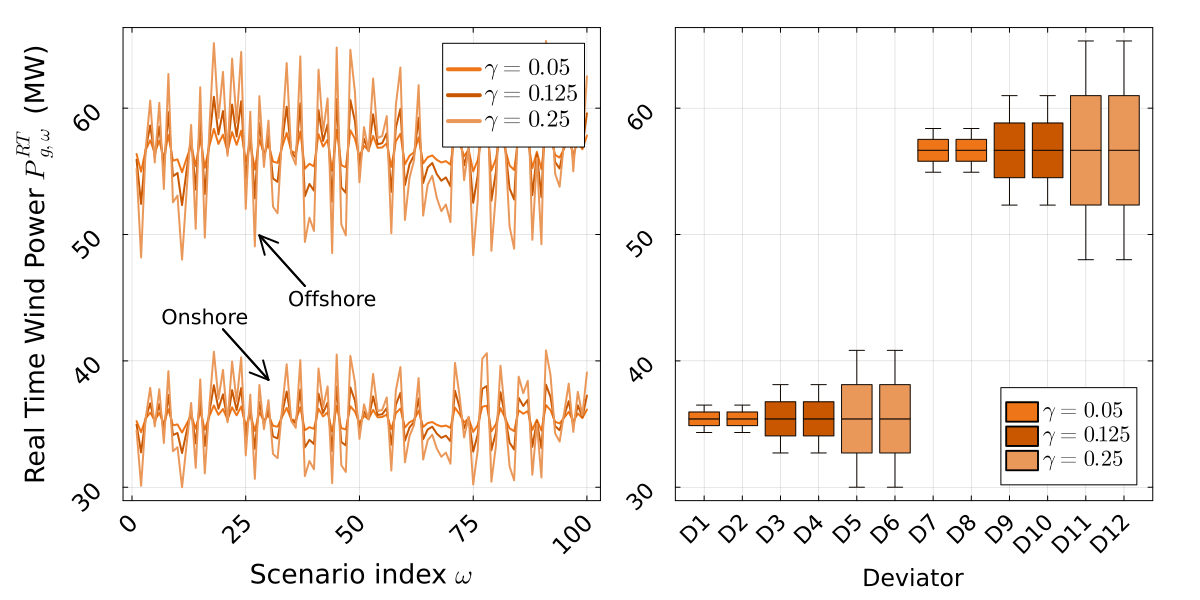

In [11]:
fig = plot_wind_power_scenarios_and_boxplots(Pw_hour, nS_all)
#savefig(fig, "../Figures/Results/Asymmetry/wind_power_scenarios_and_boxplots.pdf")

#### Asymetric Benchmark

In [12]:
time1 = time()
res_BM_asy = run_kfold_simulation("Benchmark", Pw_asy, nS_all, prob, 0, 0, k, fold_size, 
                            rf_up, rf_down,NI_up_og, NI_down_og, Cf_Rup_og,  Cf_Rdown_og, R_bids, Lambda_R, hour)
time2 = time()
println("Time for Benchmark k-fold simulation (asymmetric): ", round(time2 - time1, digits=2), " seconds.")

Fold: 1
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benchmark time: 0.47500014305114746 seconds
Fold: 2
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benchmark time: 0.026000022888183594 seconds
Fold: 3
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benchmark time: 0.01699995994567871 seconds
Fold: 4
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benchmark time: 0.020999908447265625 seconds
Fold: 5
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benchmark time: 0.018000125885009766 seconds
Fold: 6
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benchmark time: 0.01699995994567871 seconds
Fold: 7
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benchmark time: 0.021000146865844727 seconds
Fold: 8
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benchmark time: 0.019999980926513672 seconds
Fold: 9
nb of variables 543
nb of constraints 1133
Binary variables: 0
Benc

#### Asymmetric FCB Model

In [13]:
time3 = time()
res_GDCA_asy = run_kfold_simulation("TA_bin_GDCA", Pw_asy, nS_all, prob, q_up, q_down, k, fold_size, 
                            rf_up, rf_down, NI_up_og, NI_down_og, Cf_Rup_og,  Cf_Rdown_og, R_bids, Lambda_R, hour; history = res_BM_asy.history.history_insample, max_iter = 100, penalty_t = 800)
time4 = time()
println("Time for GDCA k-fold simulation (asymmetric): ", round(time4 - time3, digits=2), " seconds.")

Fold: 1
nb of variables 1323
nb of constraints 3253
Binary variables: 140
TA_bin_GDCA time: 73.20199990272522 seconds
nb of variables 1183
nb of constraints 3103
Binary variables: 0
TA_bin_LP_GDCA time: 17.118000030517578 seconds
Fold: 2
nb of variables 1323
nb of constraints 3253
Binary variables: 140
TA_bin_GDCA time: 35.15000009536743 seconds
nb of variables 1183
nb of constraints 3103
Binary variables: 0
TA_bin_LP_GDCA time: 0.05900001525878906 seconds
Fold: 3
nb of variables 1323
nb of constraints 3253
Binary variables: 140
TA_bin_GDCA time: 4.079999923706055 seconds
nb of variables 1183
nb of constraints 3103
Binary variables: 0
TA_bin_LP_GDCA time: 0.06999993324279785 seconds
Fold: 4
nb of variables 1323
nb of constraints 3253
Binary variables: 140
TA_bin_GDCA time: 58.138999938964844 seconds
nb of variables 1183
nb of constraints 3103
Binary variables: 0
TA_bin_LP_GDCA time: 0.09600019454956055 seconds
Fold: 5
nb of variables 1323
nb of constraints 3253
Binary variables: 140
TA

#### Saving the Results

In [14]:
function namedtuple_to_dict(x)
    if x isa NamedTuple
        return Dict(k => namedtuple_to_dict(v) for (k,v) in pairs(x))
    elseif x isa AbstractArray
        return [namedtuple_to_dict(v) for v in x]
    else
        return x
    end
end

# Assume your results dict is called `results`
data_asy_forecast_BM = namedtuple_to_dict(res_BM_asy)
data_asy_forecast_GDCA = namedtuple_to_dict(res_GDCA_asy)

@save "export/data_asy_forecast_BM.jld2" data_asy_forecast_BM
@save "export/data_asy_forecast_GDCA.jld2" data_asy_forecast_GDCA
